## Importações e bibliotecas

In [ ]:
import pandas             as pd
import matplotlib.pyplot  as plt

import spacy

from sklearn.model_selection          import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes              import MultinomialNB
from sklearn.pipeline                 import Pipeline
from collections                      import Counter
from wordcloud                        import WordCloud

In [ ]:
# Carregar modelo spaCy para português
!python -m spacy download pt_core_news_sm
nlp = spacy.load('pt_core_news_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 36.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Carregar datasets
df = pd.read_csv('/content/df_treino.csv', delimiter=';', encoding='latin-1')
df_teste = pd.read_csv('/content/df_teste.csv', delimiter=';', encoding='latin-1')

In [ ]:
df.sample(5)

,Tweet,Sentimento
31,Cada peça de lixo que jogamos fora de forma i...,Negativo
34,Ver a beleza dos oceanos sendo destruída pela...,Negativo
25,A poluição oceânica não é um problema distant...,Negativo
24,Estou otimista ao ver mais pessoas se conscie...,Positivo
39,Vamos ensinar nossas crianças sobre a importâ...,Positivo


In [ ]:
df_teste.sample(5)

,Tweet,Sentimento
16,Vamos tomar medidas para proteger nossos ocea...,Positivo
4,A poluição oceânica não é apenas um problema ...,Negativo
5,Cada sacola plástica que jogamos fora pode ac...,Negativo
8,Vamos parar de usar plásticos descartáveis e ...,Positivo
13,Vamos ensinar nossas crianças a importância d...,Positivo


## Modelo

In [ ]:
def processamento(texto):
    doc = nlp(texto.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

In [ ]:
# Pré-processar os comentários
df['processado'] = df['Tweet'].apply(processamento)
df_teste['processado'] = df_teste['Tweet'].apply(processamento)

In [ ]:
# Dividir os dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(df['processado'], df['Sentimento'], test_size=0.2, random_state=42)

In [ ]:
# Criar o pipeline de classificação
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Hiperparâmetros para Grid Search
param_grid = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.5, 1.0]
}

In [ ]:
# Grid Search com validação cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f'Melhores parâmetros: {grid_search.best_params_}')
pipeline = grid_search.best_estimator_

# Avaliar no conjunto de validação
acuracia = pipeline.score(X_val, y_val)
print(f'Acuracia: {acuracia:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Melhores parâmetros: {'clf__alpha': 0.5, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 1)}
Acuracia: 0.70


In [ ]:
# Classificar os comentários do dataset de teste
X_test = df_teste['processado']
predicoes = pipeline.predict(X_test)

# Adicionar as previsões ao dataframe de teste
df_teste['sentimento_predito'] = predicoes

In [ ]:
# Análise e visualização
estatisticas = df_teste['sentimento_predito'].value_counts()
print(estatisticas)

sentimento_predito
 Negativo       15
 Positivo        6
Name: count, dtype: int64


In [ ]:
df_teste

,Tweet,Sentimento,processado,sentimento_predito
0,A poluição nos oceanos é um crime contra a na...,Negativo,poluição oceano crime natureza precisar lei rí...,Negativo
1,Vamos honrar o Dia Mundial dos Oceanos compro...,Positivo,ir honrar dia mundial oceano reduzir impacto a...,Positivo
2,Os oceanos são a fonte de vida do nosso plane...,Positivo,oceano fonte vida planeta dever poluição desca...,Negativo
3,Estou enojado com a quantidade de lixo que fl...,Negativo,enojar quantidade lixo flutuar oceano sociedad...,Negativo
4,A poluição oceânica não é apenas um problema ...,Negativo,poluição oceânico problema ambiental crise glo...,Negativo
5,Cada sacola plástica que jogamos fora pode ac...,Negativo,sacola plástico jogamos acabar matar tartaruga...,Negativo
6,Parabéns a todos que trabalham incansavelment...,Positivo,parabéns trabalhar incansavelmente limpar prai...,Positivo
7,A poluição oceânica é um problema que afeta a...,Negativo,poluição oceânico problema afetar independente...,Negativo
8,Vamos parar de usar plásticos descartáveis e ...,Positivo,ir parar plástico descartável adotar alternati...,Positivo
9,A poluição oceânica não é um problema distant...,Negativo,poluição oceânico problema distante acontecer ...,Negativo


## Extração de entidades e informações

In [ ]:
# Função para extrair entidades nomeadas de um texto
def extrair_entidades(texto):
    doc = nlp(texto)
    entidades = [(entidade.text, entidade.label_) for entidade in doc.ents]
    return entidades

# Aplicar a função aos tweets do dataset
df['entidades_nomeadas'] = df['Tweet'].apply(extrair_entidades)
df

,Tweet,Sentimento,processado,entidades,entidades_nomeadas
0,A poluição nos oceanos está fora de controle!...,Negativo,poluição oceano controle precisar agir salvar ...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}","[(Precisamos, LOC), (SOSOceans ..."
1,Parabéns às ONGs que lutam diariamente contra...,Positivo,parabéns ong lutar diariamente poluição oceâni...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}","[(Parabéns, ORG), (ONGs, ORG), (AçãoAmbiental,..."
2,O descarte correto de lixo é uma responsabili...,Neutro,descarte correto lixo responsabilidade ir info...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}","[(ConsciênciaAmbiental , LOC)]"
3,É revoltante ver a quantidade de lixo que vai...,Negativo,revoltante quantidade lixo parar oceano dias p...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}",[]
4,Cada vez mais empresas estão adotando prática...,Positivo,empresa adotar prática sustentável passo impor...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}","[(Sustentabilidade, PER), (Oceans, LOC)]"
5,Ver escolas ensinando sobre a importância da ...,Positivo,escola ensinar importância preservação ambient...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}","[(EducaçãoAmbiental, MISC)]"
6,Desolador ver a quantidade de lixo acumulado ...,Negativo,desolador quantidade lixo acumular oceano esta...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}","[(Desolador, PER), (CriseAmbiental , M..."
7,"Pequenas atitudes, como reduzir o uso de canu...",Positivo,pequeno atitude reduzir uso canudo plástico aj...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}","[(MenosPlástico, LOC)]"
8,Cansado de ver tartarugas e outros animais ma...,Negativo,cansar tartaruga animal marinho sofrer causa l...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}",[]
9,É inaceitável ver tanto lixo plástico nas pra...,Negativo,inaceitável lixo plástico praia ir aprender cu...,"{'LOC': [], 'PER': [], 'ORG': [], 'MISC': []}","[(AcordaHumanidade , LOC)]"


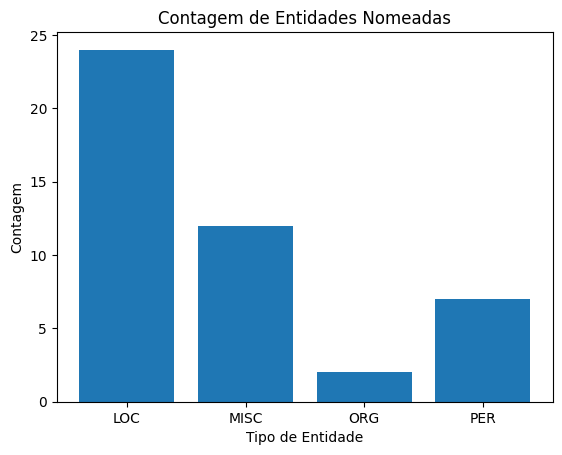

In [ ]:
import matplotlib.pyplot as plt

# Exemplo de visualização de entidades mais frequentes
entidades_count = Counter([entidade[1] for entidades in df['entidades_nomeadas'] for entidade in entidades])
plt.bar(entidades_count.keys(), entidades_count.values())
plt.xlabel('Tipo de Entidade')
plt.ylabel('Contagem')
plt.title('Contagem de Entidades Nomeadas')
plt.show()